In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import time
import pickle

In [2]:
df = pd.read_csv('green_trip_data_2018-9clean.csv')

In [3]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
lpep_pickup_datetime,2018-09-01 00:52:38,2018-09-01 00:32:40,2018-09-01 00:07:55,2018-09-01 00:53:25,2018-09-01 00:14:33
lpep_dropoff_datetime,2018-09-01 01:05:00,2018-09-01 00:47:18,2018-09-01 00:15:19,2018-09-01 00:58:03,2018-09-01 00:30:57
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
fare_amount,17.0,13.5,8.5,5.0,14.5
extra,0.5,0.5,0.5,0.5,0.5
mta_tax,0.5,0.5,0.5,0.5,0.5


In [4]:
def extract_coordinates(coord_str):
    coord_str = coord_str.strip('()')
    x, y = map(float, coord_str.split(', '))
    return x, y

df['pickup_location_coordinates_x'], df['pickup_location_coordinates_y'] = zip(*df['pickup_location_coordinates'].apply(extract_coordinates))
df['dropoff_location_coordinates_x'], df['dropoff_location_coordinates_y'] = zip(*df['dropoff_location_coordinates'].apply(extract_coordinates))

df.drop(columns=['pickup_location_coordinates', 'dropoff_location_coordinates'], inplace=True)

Extracting the x and y coordinates from the 'pickup_location_coordinates' and 'dropoff_location_coordinates' into 4 new columns.

In [5]:
cols = ['Unnamed: 0', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'pickup_location_coordinates_missing', 'dropoff_location_coordinates_missing']
df = df.drop(cols, axis=1)

In [6]:
df = pd.get_dummies(df)

One hot encoding for the date_range

In [7]:
column_names = df.columns.tolist()
print(column_names)

['pu_location', 'do_location', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'week_number', 'vendor_Creative Mobile Technologies, LLC', 'vendor_Unknown', 'vendor_VeriFone Inc.', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'rate_type_Group ride', 'rate_type_JFK', 'rate_type_Nassau or Westchester', 'rate_type_Negotiated fare', 'rate_type_Newark', 'rate_type_Standard rate', 'rate_type_Unknown', 'payment_type_Cash', 'payment_type_Credit card', 'payment_type_Dispute', 'payment_type_No charge', 'payment_type_Unknown', 'trip_type_Dispatch', 'trip_type_Street-hail', 'trip_type_Unknown', 'pickup_hour', 'trip_duration_min', 'cost_per_mile', 'pickup_location_coordinates_x', 'pickup_location_coordinates_y', 'dropoff_location_coordinates_x', 'dropoff_location_coordinates_y', 'date_range_2018-08-27/2018-09-02', 'date_range_2018-09-03/2018-09-09', 'date_range_2018-09-10/2018-09-16', 'date_range_2018-09

In [8]:
df['trip_price'] = pd.cut(df['total_amount'], bins=3, labels=['low', 'medium', 'high'])
cols = ['total_amount','fare_amount','extra','tip_amount','tolls_amount']
df = df.drop(cols, axis=1)


In [9]:
df.head().T

,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
mta_tax,0.5,0.5,0.5,0.5,0.5
improvement_surcharge,0.3,0.3,0.3,0.3,0.3
week_number,35,35,35,35,35
"vendor_Creative Mobile Technologies, LLC",False,False,False,False,False
vendor_Unknown,False,False,False,False,False
vendor_VeriFone Inc.,True,True,True,True,True


Discretizing the trip price into low, medium, and high

In [10]:
le = LabelEncoder()
df['trip_price'] = le.fit_transform(df['trip_price'])

In [11]:
df.head().T

,0,1,2,3,4
pu_location,160,180,71,79,64
do_location,205,186,75,100,100
passenger_count,1.0,5.0,1.0,1.0,2.0
trip_distance,5.47,3.47,1.9,0.69,3.83
mta_tax,0.5,0.5,0.5,0.5,0.5
improvement_surcharge,0.3,0.3,0.3,0.3,0.3
week_number,35,35,35,35,35
"vendor_Creative Mobile Technologies, LLC",False,False,False,False,False
vendor_Unknown,False,False,False,False,False
vendor_VeriFone Inc.,True,True,True,True,True


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681899 entries, 0 to 681898
Data columns (total 44 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   pu_location                               681899 non-null  int64  
 1   do_location                               681899 non-null  int64  
 2   passenger_count                           681899 non-null  float64
 3   trip_distance                             681899 non-null  float64
 4   fare_amount                               681899 non-null  float64
 5   extra                                     681899 non-null  float64
 6   mta_tax                                   681899 non-null  float64
 7   tip_amount                                681899 non-null  float64
 8   tolls_amount                              681899 non-null  float64
 9   improvement_surcharge                     681899 non-null  float64
 10  week_number         

In [12]:
df.to_csv('cleaned_dropped.csv')

In [13]:
df = pd.read_csv('cleaned_dropped.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

- Splits the DataFrame into input features (X) and the target variable (y:trip_price).
- Divides the data into training and testing sets using an 80/20 split
- Standardizes the features to have a mean of 0 and a standard deviation of 1, which improves the performance of many machine learning algorithms.

Loaded the dataset into df after discretizing the trip_price into 3 categories 0: high, 1: low, and 2: medium. Split the dataset into the input X which contains all columns but the last one 'trip_price' which is the output y. Then split the X and y into train and test sets. And finally, normalized the dataset.

In [14]:
df['trip_price'].value_counts()
#To understand the distribution of the classes in the dataset

trip_price
1    436326
2    123276
0    122297
Name: count, dtype: int64

In [16]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


One of the diagnostics explained in the lecture is the use of Random Resampling as on of the ways to solve the issue that original data might not be enough to make a sufficiently large training. Therefore to Random resample  i created new training datasets, denoted as X_train_resampled and y_train_resampled, by randomly duplicating or generating new instances from the original data. This process aims to tackle issues stemming from imbalanced class distributions or insufficient data points for certain classes. By ensuring a more balanced representation of classes and increasing the overall size of the training set.

## Classification

In [15]:
accuracies = []
train_time = []
prediction_time = []
models = ['KNN', 'Logistic Regression', 'Decision Trees', 'Random Forest', 'Naive Bayes']

These are for comparing all models after training them.

### KNN

In [59]:
knn = KNeighborsClassifier()

optimal_k = round(np.sqrt(X_train.shape[0])/2)
optimal_k2 = round(np.sqrt(X_train.shape[0]))

n_neighbors = list(np.arange(2,20,1))
n_neighbors.append(optimal_k)
n_neighbors.append(optimal_k2)
p = [1,2]

params = {
    'n_neighbors': n_neighbors,
    'p': p
}

knn_gscv_drop = GridSearchCV(estimator=knn, param_grid=params, cv=3, verbose=3)
knn_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[CV 1/3] END ................n_neighbors=2, p=1;, score=0.906 total time=17.5min
[CV 2/3] END ................n_neighbors=2, p=1;, score=0.907 total time=21.2min
[CV 3/3] END ................n_neighbors=2, p=1;, score=0.906 total time=17.2min
[CV 1/3] END ................n_neighbors=2, p=2;, score=0.906 total time= 3.6min
[CV 2/3] END ................n_neighbors=2, p=2;, score=0.906 total time= 3.3min
[CV 3/3] END ................n_neighbors=2, p=2;, score=0.905 total time= 3.3min
[CV 1/3] END ................n_neighbors=3, p=1;, score=0.921 total time=18.1min
[CV 2/3] END ................n_neighbors=3, p=1;, score=0.921 total time=23.2min
[CV 3/3] END ................n_neighbors=3, p=1;, score=0.920 total time=16.9min
[CV 1/3] END ................n_neighbors=3, p=2;, score=0.917 total time= 3.6min
[CV 2/3] END ................n_neighbors=3, p=2;, score=0.917 total time= 3.6min
[CV 3/3] END ................n_neighbors=3, p=2;, score=0.916 total time= 3.7min
[CV 1/3] END ...............

In [ ]:
optimal_k, optimal_k2

(369, 739)

For the KNN and all the other models, I used GridSearchCV which is a scikit-learn tool that takes as parameters the model (estimator) and all of the parameters of the model that I want to use (param_grid), then train the data using these parameters with each other so because I tried 2 parameteres 'n_neighbors' and 'p' with 20 and 2 values respectively, it will train the model 40 times with different combinations of parameters. Furthermore, I specified the cv to be equal to 3 which means that for each iteration the model will split the data into 3 sets, one will be used for testing and the other 2 for training. Then the second will be used for testing and then the third will be used for testing while training with the other 2. So for each combination of parameters, there will be 3 trainings which means the total models trained will be equal to 120. For each iteration, a score will be calculated and for each model combination of parameters the score will be the average of the three models trained. I tried different values for the 'n_neighbors' parameter ranging from 2 to 20 as well as 369 and 739 as I found that sometimes the optimal values for this parameter might be the sqaure root of the number of samples and half the square root of the number of samples. I tried all these values twice, each time for a different distance metric specified by the 'p' parameter which indicates the euclidean or manhattan distances.

In [ ]:
pickle.dump(knn_gscv_drop, open('knn_gscv_drop.pkl', 'wb'))

NameError: name 'knn_gscv' is not defined

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [18]:
knn_gscv_drop = pickle.load(open('knn_gscv_drop.pkl', 'rb'))

c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\anacon\envs\data_eng\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [19]:
knn_gscv_drop.best_estimator_, knn_gscv_drop.best_params_, knn_gscv_drop.best_score_

(KNeighborsClassifier(n_neighbors=7, p=1),
 {'n_neighbors': 7, 'p': 1},
 0.9573452058145634)

In [20]:
# knn_gscv.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\anacon\envs\data_eng\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[CV 1/3] END ................n_neighbors=2, p=1;, score=0.976 total time=83.8min
[CV 2/3] END ...............n_neighbors=2, p=1;, score=0.982 total time=648.0min
[CV 3/3] END ................n_neighbors=2, p=1;, score=0.981 total time=76.8min
[CV 1/3] END ................n_neighbors=2, p=2;, score=0.973 total time=15.9min
[CV 2/3] END ................n_neighbors=2, p=2;, score=0.979 total time=14.5min
[CV 3/3] END ................n_neighbors=2, p=2;, score=0.979 total time=14.5min
[CV 1/3] END ................n_neighbors=3, p=1;, score=0.972 total time=76.3min
[CV 2/3] END ................n_neighbors=3, p=1;, score=0.976 total time=94.5min


I can then access the GridSearchCV attributes which can tell the best model, parameters, and score. Which can then be used to train on the full training data and tested on the test data.

In [21]:
train_time.append(knn_gscv_drop.refit_time_)

In [22]:
accuracies.append(knn_gscv_drop.best_score_)

In [23]:
t_start = time.time()
y_preds = knn_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

Appending the results into the lists I initiated at the start for later comparisons.

In [24]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     24373
           1       0.97      0.99      0.98     87290
           2       0.91      0.87      0.89     24717

    accuracy                           0.96    136380
   macro avg       0.95      0.94      0.94    136380
weighted avg       0.96      0.96      0.96    136380



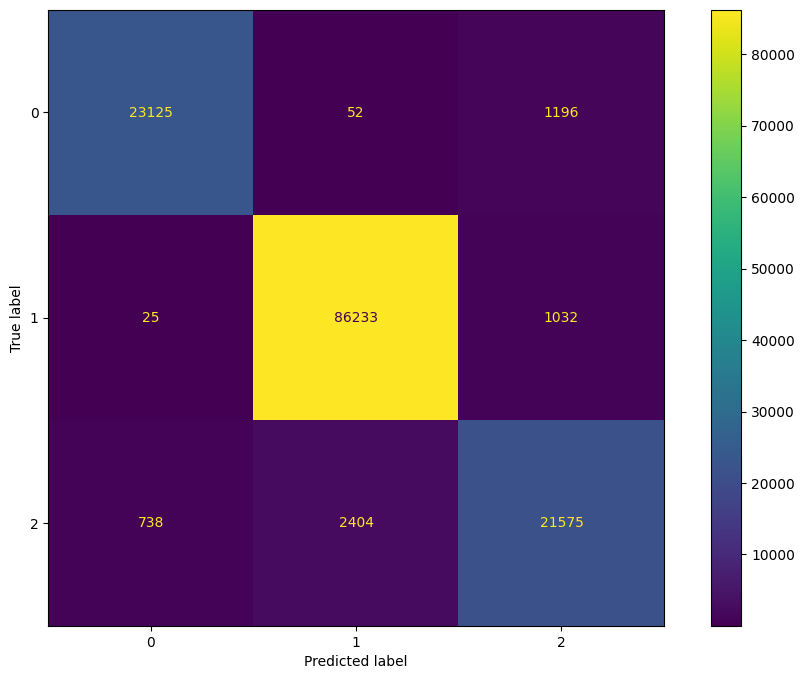

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Logistic Regression

In [18]:
lr = LogisticRegression()

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 500, 1000]
}

lr_gscv_drop = GridSearchCV(estimator=lr, param_grid=params, cv=3, verbose=3)
lr_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END .............C=0.001, max_iter=100;, score=0.915 total time=   7.2s
[CV 2/3] END .............C=0.001, max_iter=100;, score=0.915 total time=   7.9s
[CV 3/3] END .............C=0.001, max_iter=100;, score=0.915 total time=   6.8s
[CV 1/3] END .............C=0.001, max_iter=500;, score=0.915 total time=   8.5s
[CV 2/3] END .............C=0.001, max_iter=500;, score=0.915 total time=   9.1s
[CV 3/3] END .............C=0.001, max_iter=500;, score=0.915 total time=   7.5s
[CV 1/3] END ............C=0.001, max_iter=1000;, score=0.915 total time=   9.6s
[CV 2/3] END ............C=0.001, max_iter=1000;, score=0.915 total time=   7.7s
[CV 3/3] END ............C=0.001, max_iter=1000;, score=0.915 total time=   6.7s
[CV 1/3] END ..............C=0.01, max_iter=100;, score=0.925 total time=  10.5s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ..............C=0.01, max_iter=100;, score=0.925 total time=  11.9s
[CV 3/3] END ..............C=0.01, max_iter=100;, score=0.924 total time=  15.5s
[CV 1/3] END ..............C=0.01, max_iter=500;, score=0.925 total time=  14.0s
[CV 2/3] END ..............C=0.01, max_iter=500;, score=0.925 total time=  22.2s
[CV 3/3] END ..............C=0.01, max_iter=500;, score=0.924 total time=  13.2s
[CV 1/3] END .............C=0.01, max_iter=1000;, score=0.925 total time=   9.9s
[CV 2/3] END .............C=0.01, max_iter=1000;, score=0.925 total time=  13.3s
[CV 3/3] END .............C=0.01, max_iter=1000;, score=0.924 total time=  12.5s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ...............C=0.1, max_iter=100;, score=0.926 total time=  12.7s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ...............C=0.1, max_iter=100;, score=0.926 total time=  12.5s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ...............C=0.1, max_iter=100;, score=0.926 total time=  12.3s
[CV 1/3] END ...............C=0.1, max_iter=500;, score=0.926 total time=  23.3s
[CV 2/3] END ...............C=0.1, max_iter=500;, score=0.926 total time=  20.0s
[CV 3/3] END ...............C=0.1, max_iter=500;, score=0.925 total time=  17.2s
[CV 1/3] END ..............C=0.1, max_iter=1000;, score=0.926 total time=  23.6s
[CV 2/3] END ..............C=0.1, max_iter=1000;, score=0.926 total time=  20.0s
[CV 3/3] END ..............C=0.1, max_iter=1000;, score=0.925 total time=  17.2s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .................C=1, max_iter=100;, score=0.927 total time=  11.4s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .................C=1, max_iter=100;, score=0.926 total time=  11.5s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END .................C=1, max_iter=100;, score=0.926 total time=  11.4s
[CV 1/3] END .................C=1, max_iter=500;, score=0.927 total time=  14.5s
[CV 2/3] END .................C=1, max_iter=500;, score=0.926 total time=  17.2s
[CV 3/3] END .................C=1, max_iter=500;, score=0.926 total time=  16.6s
[CV 1/3] END ................C=1, max_iter=1000;, score=0.927 total time=  14.4s
[CV 2/3] END ................C=1, max_iter=1000;, score=0.926 total time=  16.0s
[CV 3/3] END ................C=1, max_iter=1000;, score=0.926 total time=  16.5s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ................C=10, max_iter=100;, score=0.927 total time=  12.0s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ................C=10, max_iter=100;, score=0.926 total time=  12.3s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ................C=10, max_iter=100;, score=0.926 total time=  12.5s
[CV 1/3] END ................C=10, max_iter=500;, score=0.927 total time=  14.4s
[CV 2/3] END ................C=10, max_iter=500;, score=0.926 total time=  16.4s
[CV 3/3] END ................C=10, max_iter=500;, score=0.926 total time=  17.9s
[CV 1/3] END ...............C=10, max_iter=1000;, score=0.927 total time=  14.2s
[CV 2/3] END ...............C=10, max_iter=1000;, score=0.926 total time=  15.1s
[CV 3/3] END ...............C=10, max_iter=1000;, score=0.926 total time=  16.9s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ...............C=100, max_iter=100;, score=0.927 total time=  11.0s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ...............C=100, max_iter=100;, score=0.926 total time=  11.7s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ...............C=100, max_iter=100;, score=0.926 total time=  11.2s
[CV 1/3] END ...............C=100, max_iter=500;, score=0.927 total time=  13.3s
[CV 2/3] END ...............C=100, max_iter=500;, score=0.926 total time=  18.5s
[CV 3/3] END ...............C=100, max_iter=500;, score=0.926 total time=  15.6s
[CV 1/3] END ..............C=100, max_iter=1000;, score=0.927 total time=  14.4s
[CV 2/3] END ..............C=100, max_iter=1000;, score=0.926 total time=  18.1s
[CV 3/3] END ..............C=100, max_iter=1000;, score=0.926 total time=  15.8s


c:\anacon\envs\data_eng\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000]},
             verbose=3)

Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [19]:
pickle.dump(lr_gscv_drop , open('lr_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [20]:
lr_gscv_drop= pickle.load(open('lr_gscv_drop.pkl', 'rb'))

In [21]:
lr_gscv_drop.best_estimator_, lr_gscv_drop.best_params_, lr_gscv_drop.best_score_

(LogisticRegression(C=100), {'C': 100, 'max_iter': 100}, 0.9262262165328748)

Best model, parameters, and score

In [22]:
train_time.append(lr_gscv_drop.refit_time_)

In [23]:
accuracies.append(lr_gscv_drop.best_score_)

In [24]:
t_start = time.time()
y_preds = lr_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

Appending the results into the lists I initiated at the start for later comparisons.

In [25]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     24373
           1       0.96      0.97      0.97     87290
           2       0.81      0.78      0.79     24717

    accuracy                           0.93    136380
   macro avg       0.89      0.89      0.89    136380
weighted avg       0.93      0.93      0.93    136380



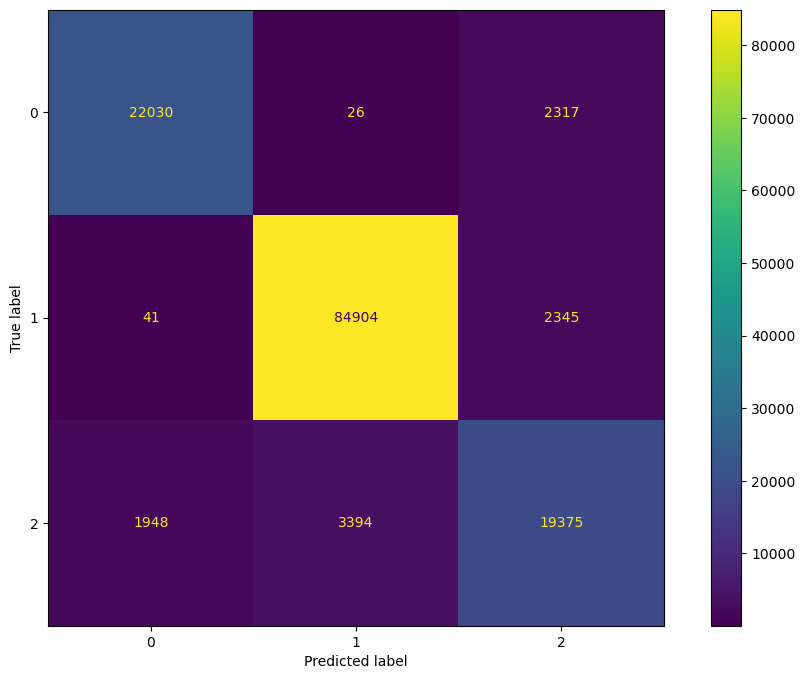

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Decision Trees

In [27]:
dt = DecisionTreeClassifier()

params = {
    'max_depth': [None, 2, 4, 8, 10],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

dt_gscv_drop= GridSearchCV(estimator=dt, param_grid=params, cv=3, verbose=3)
dt_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 160 candidates, totalling 480 fits
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.996 total time=  11.3s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.996 total time=  10.5s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2;, score=0.996 total time=  10.7s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.996 total time=  11.3s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.996 total time=  12.0s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=4;, score=0.996 total time=  11.0s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6;, score=0.996 total time=  13.8s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6;, score=0.996 total time= 

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 8, 10],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 6, 8]},
             verbose=3)

Again, GridSearchCV is used to get the best decision tree model using the parameters specified in the 'params' dictionary.

In [31]:
pickle.dump(dt_gscv_drop, open('dt_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [32]:
dt_gscv_drop = pickle.load(open('dt_gscv_drop.pkl', 'rb'))

In [33]:
dt_gscv_drop.best_estimator_, dt_gscv_drop.best_params_, dt_gscv_drop.best_score_

(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                        min_samples_split=4),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 4},
 0.9972173284258014)

Best model, parameters, and score

In [34]:
train_time.append(dt_gscv_drop.refit_time_)

In [35]:
accuracies.append(dt_gscv_drop.best_score_)

In [36]:
t_start = time.time()
y_preds = dt_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

Appending the results into the lists I initiated at the start for later comparisons.

In [37]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24373
           1       1.00      1.00      1.00     87290
           2       0.99      0.99      0.99     24717

    accuracy                           1.00    136380
   macro avg       1.00      1.00      1.00    136380
weighted avg       1.00      1.00      1.00    136380



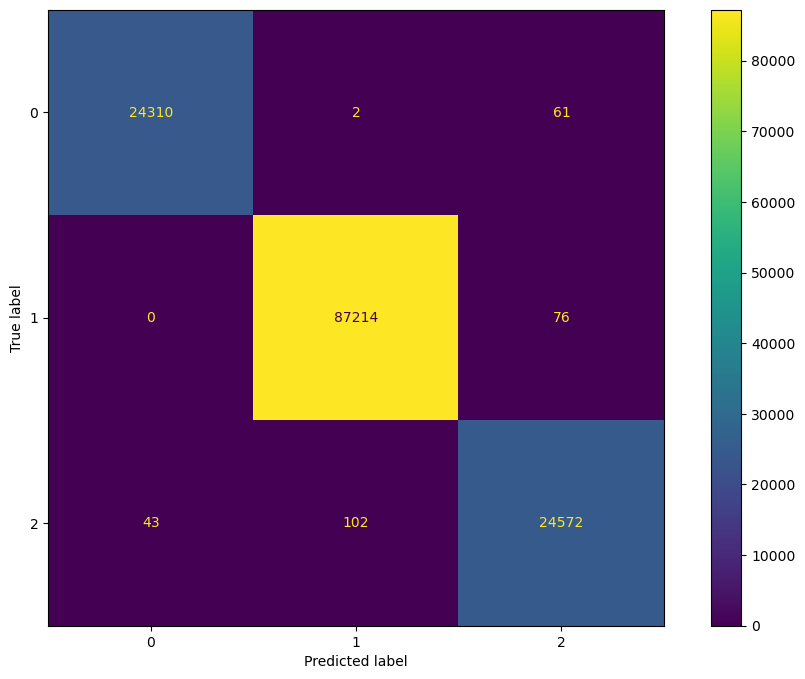

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Random Forest

In [39]:
rf = RandomForestClassifier()

params = {
    'n_estimators': [2, 4, 8, 16, 32, 100, 200],
    'max_depth': [None, 2],
    'min_samples_split': [6, 8],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf_gscv_drop = GridSearchCV(estimator=rf, param_grid=params, cv=3, verbose=3)
rf_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.951 total time=   2.6s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.954 total time=   2.5s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=2;, score=0.952 total time=   2.8s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.974 total time=   6.3s
[CV 2/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.969 total time=   6.9s
[CV 3/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=4;, score=0.968 total time=   6.7s
[CV 1/3] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=8;, score=0.976 total time=  14.2s

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [6, 8],
                         'n_estimators': [2, 4, 8, 16, 32, 100, 200]},
             verbose=3)

GridSearchCV is used to get the best random forest model using the parameters specified in the 'params' dictionary.

In [40]:
pickle.dump(rf_gscv_drop, open('rf_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [41]:
rf_gscv_drop = pickle.load(open('rf_gscv_drop.pkl', 'rb'))

In [42]:
rf_gscv_drop.best_estimator_, rf_gscv_drop.best_params_, rf_gscv_drop.best_score_

(RandomForestClassifier(criterion='entropy', min_samples_split=6,
                        n_estimators=200),
 {'criterion': 'entropy',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 200},
 0.9833699640067705)

Best model, parameters, and score

In [43]:
train_time.append(rf_gscv_drop.refit_time_)

In [44]:
accuracies.append(rf_gscv_drop.best_score_)

In [45]:
t_start = time.time()
y_preds = rf_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

Appending the results into the lists I initiated at the start for later comparisons.

In [46]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     24373
           1       0.99      0.99      0.99     87290
           2       0.96      0.96      0.96     24717

    accuracy                           0.99    136380
   macro avg       0.98      0.98      0.98    136380
weighted avg       0.99      0.99      0.99    136380



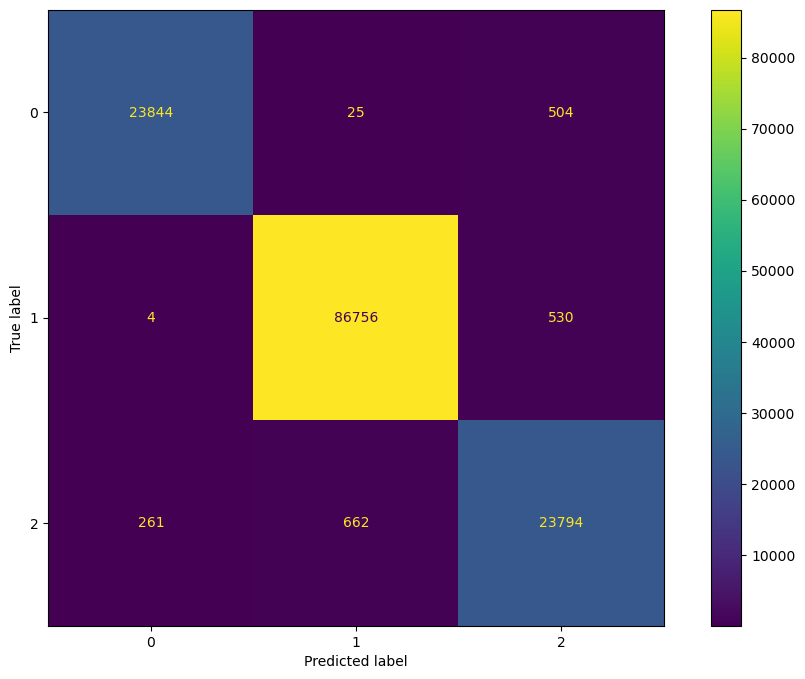

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

## Naive Bayes

In [48]:
nb = GaussianNB()

params = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb_gscv_drop = GridSearchCV(estimator=nb, param_grid=params, cv=3, verbose=3, n_jobs=-1)
nb_gscv_drop.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

The GridSearchCV doesn't output anything using the GaussianNB classifier however the trainig time didn't take long and it outputted the needed results. One reason for not outputting anything I found is that there is no parameter tuning for the GaussianNB.

'var_smoothing' is a stability calculation to widen (or smooth) the curve and therefore account for more samples that are further away from the distribution mean. 

In [49]:
pickle.dump(nb_gscv_drop, open('nb_gscv_drop.pkl', 'wb'))

Saving the model into a pickle file so that we don't need to train it again if the kernel was shut down.

In [50]:
nb_gscv_drop = pickle.load(open('nb_gscv_drop.pkl', 'rb'))

In [51]:
nb_gscv_drop.best_estimator_, nb_gscv_drop.best_params_, nb_gscv_drop.best_score_

(GaussianNB(var_smoothing=0.0004328761281083057),
 {'var_smoothing': 0.0004328761281083057},
 0.7542578510392617)

Best model, parameters, and score

In [52]:
train_time.append(nb_gscv_drop.refit_time_)

In [53]:
accuracies.append(nb_gscv_drop.best_score_)

In [54]:
t_start = time.time()
y_preds = nb_gscv_drop.predict(X_test)
t_end = time.time()
total_time = t_end - t_start
prediction_time.append(total_time)

Appending the results into the lists I initiated at the start for later comparisons.

In [55]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.62      0.26      0.36     24373
           1       0.95      0.89      0.92     87290
           2       0.43      0.76      0.55     24717

    accuracy                           0.76    136380
   macro avg       0.66      0.64      0.61    136380
weighted avg       0.80      0.76      0.75    136380



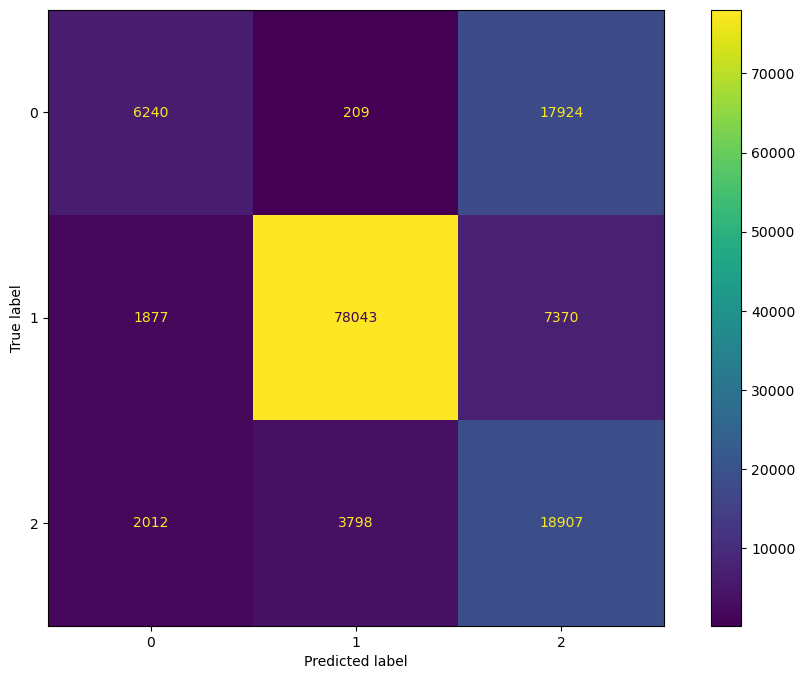

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))

cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels=None)
cmp.plot(ax=ax)

plt.show();

This graph show the predicted values vs the actual values.

# Comparison

In [57]:
data_dict = {'accuracies': accuracies, 'train_time (sec)': train_time, 'prediction_time (sec)': prediction_time}
compare_df = pd.DataFrame({col: np.nan for col in data_dict.keys()}, index=models)

for col, data in data_dict.items():
    compare_df.loc[compare_df.index[:len(data)], col] = data


In [58]:
compare_df

,accuracies,train_time (sec),prediction_time (sec)
KNN,0.926226,17.817131,0.026677
Logistic Regression,0.997217,8.090701,0.033653
Decision Trees,0.983370,420.051004,7.654379
Random Forest,0.754258,0.741530,0.264634
Naive Bayes,NaN,NaN,NaN


Overall, Logistic regression, decision trees, and random forest had the better accuracies with all of them achieving over 99% accuracy, on the contrary, NB had the worst accuracy by about 13% less than KNN with 95%. Difference between accuracies are not that much between the former three with decision trees ~0.2% better than random forest and ~0.5% better than logistic regression. Furthermore, decision trees had the second least training time between them and fourth overall between all models as well as the second lowest prediction time but only with ~0.002s more than logistic regression. So decision trees seems to be the best option for this dataset.